# Mixed Layer Depth: Hovmoller plots

On this notebook we find described the code used to get a plot of the zonal mean seasonal cycle of the mixed layer depth in the regions named in the notebook [Regions](./Distribution-regions.ipynb). 

For the sake of brevity, the notebook only considers one example for one of the regions, the Gulf Stream. This notebook has the following structure:

   [1. Imported modules](#1.-Imported-modules)
   [2. Dictionaries used](#2.-Dictionaries-used)
   [3. Functions](#3.-Functions)
   [4. Example plot](#4.-Example-plot)
    
Figures of this kind can be found in the written report [MLD project](https://www.overleaf.com/read/rmjfbdbbrsbf
), in the Section (3.3.1), (4.3.1), (5.3.1) and Chapter 6. In the case of the figure for the Labrador and Irminger seas the plot is done using the meridional mean of the seasonal cycle. The change will be show as a comented line in the fllowing sections.

## 1. Imported modules

In [1]:
#!/bin/python3

#########################
######### ROUTINE TO PLOT THE SEASONAL MEAN OF ANY VARIABLE OVER AN ALREADY 
######### SELECTED REGION.
#########################


import cartopy
import cartopy.feature as cfeat
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

import xarray as xr
import numpy as np

import datetime
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable

## This module disable the print of warnings in the notebook
import warnings; warnings.simplefilter('ignore')

## 2. Dictionaries used

In [2]:
"""
reg_ext is a dictionary that has the coordinate
boundaries of the main regions. The format is:
<region> :
  <lon> : (lon1, lon2)
  <lat> : (lat1,  lat2)
  <name> : title for an eventual ploting title
"""

reg_ext = {
    'lab': {
        'lon' : (-60, -30),
        'lat' : (50, 65),
        'name' : 'Labrador and Irminger Seas'
    },
    'gul': {
        'lon' : (-75, -45),
        'lat' : (30, 45),
        'name' : 'Gulf Stream'
    },
    'noe': {
        'lon' : (-30, -5),
        'lat' : (45, 60),
        'name' : 'North East Sea'
    },
    'nor':{
        'lon' : (-25, 20),
        'lat' : (65, 80),
        'name' : 'North Atlantic Ocean'
    },
    'noa':{
        'lon' : (-90, 50.),
        'lat' : (10, 85),
        'name' : 'North Atlantic Ocean'
    }
}


## 3. Functions

In [3]:
def Crops(coord, d_set, dic):
    """Crops is a function that takes a data set and crops it into a 
    smaller region, using as parameters the values given by the dictionary. 
        
    Parameters:
    ------------
    coord : string
        Key value that identifies the region to obtain.

    d_set : DataArray
        Dataset to be cropped.

    dic : dictionary
        Dictionary with the boundaries of the regions.

    Output:
    -------
    new_ds : DataArray
        New data array corresponding to the region stated by 'coord'.
    """
    
    lon1, lon2 = dic[coord]['lon']
    lat1, lat2 = dic[coord]['lat']
    name_fig = dic[coord]['name']
    
    new_ds = d_set.sel(longitude=slice(lon1, lon2), latitude=slice(lat1, lat2))
    return(new_ds)



def Grid(data_set):
    x = data_set.longitude
    y = data_set.latitude
    
    x, y = np.meshgrid(x, y)
    return(x, y)


def No_nan(a):
    """
        No_nan is a function that helps to filter an array from nan values.
        
        Parameters:
        ------------
        a : Numpy Array
            Is the array we want to filter
        
        Output:
        -------
        a2 : Numpy Arrray
            Array with no nan values in it
    """
    nan_array = np.isnan(a)
    not_nan_array = ~ nan_array
    a2 = a[not_nan_array]
    
    return(a2)




def Plot_Contours(data_set, reg, minl, maxl, nlevs, nlines, tstep=None, cmap=None):
    lon1, lon2 = reg_ext[reg]['lon']
    lat1, lat2 = reg_ext[reg]['lat']
    xtik = np.linspace(lon1, lon2, num=5)
    ytik = np.linspace(lat1, lat2, num=4)

    x_n, y_n = Grid(data_set)

    projection = ccrs.PlateCarree(360)
    region = [lon1, lon2, lat1, lat2]    #Lon, Lat
    
    if not cmap:
        cmap = 'magma_r'
    
    fig, ax = plt.subplots(nrows=1, ncols=1, subplot_kw=dict(projection=projection), figsize=(10,5))    
    
    Map(ax, region, xtik, ytik)
    
    if tstep==None:
        contr1 = ax.contourf(x_n, y_n, data_set.mlotst, levels=np.linspace(minl, maxl, nlevs),
                                     cmap=cmap, extend='both')
        contr2 = ax.contour(x_n, y_n, data_set.zo[0], nlines, linewidths=0.5, colors='k')
        cbar = fig.colorbar(contr1, ax=ax, shrink=0.855, orientation='vertical',
                            label='MLD [m]', extend='both')  
        #cbar.set_clim(10,120)
    else:
        contr1 = ax.contourf(x_n, y_n, data_set.mlotst[tstep], levels=np.linspace(minl, maxl, nlevs),
                                     cmap=cmap, extend='both')
        contr2 = ax.contour(x_n, y_n, data_set.zo[tstep,0], nlines, linewidths=0.5, colors='k')
        cbar = fig.colorbar(contr1, ax=ax, shrink=0.855, orientation='vertical',
                            label='MLD [m]', extend='both')  
        #cbar.set_clim(10,120)

    #fig.savefig(os.path.abspath(os.path.sep.join([".","dummy_images","Noe_%0.4d.png" % it])))
    #plt.close(fig)
    plt.show()


def Masking(data_set, cond):
    """
        Maskin is a function that makes a mask of an array depending on the 
        entering condition. The condition is evaluated over finite numbers.
        At the final, the mask is appended in the original DataArray as a 
        new coordinate.
        
        Parameters:
        ------------
        data_set : DataArray
            Is the array we want to make the mask of.
            
        cond : array
            Codition to meet. 


        Output:
        -------
        data_set : Numpy Arrray
            Array with new coordinates 'mask'
    """
    
    mask = 1 * np.ones((data_set.dims['latitude'], data_set.dims['longitude'])) * np.isfinite(cond)  
    data_set.coords['mask'] = (('latitude', 'longitude'), mask)
    return(data_set)

## 4. Example plot

In [4]:
###############################################################################
###########         MAIN PROGRAM
###############################################################################

dir_1 = '../../../New_ARMOR/'
dir_15 = '/net/data0-gw/data0/project/drakkar/USERS/lgarcia/data_ARMOR/'
dir_o = '/home/lgarcia/Documents/Scripts/Images_01/'

fl_n1 = 'NARMOR_*.nc'
fl_n15 = 'ARMOR_*.nc'


## It is needed to open both datasets because we need vertical variables
## and the NARMOR_* dataset is just a 2D data set. Therefore, we need
## the old ARMOR version ARMOR_* to get the vertical information. 
c_armor1 = xr.open_mfdataset(dir_1 + fl_n1, concat_dim='time')
c_armor15 = xr.open_mfdataset(dir_15 + fl_n15)

In [5]:
## Add time tags to the dataset

d1 = datetime.datetime(2005,1,1)
d2 = datetime.datetime(2018,12,20)

weeks = pd.date_range(start=d1, end=d2, freq='7D')
c_armor1.coords['time'] = (('time'), weeks)

In [6]:
## Filter:: using just deep ocean h>2000m
## For Nor::18, otherwise, 25
c_armor15 = Masking(c_armor15, c_armor15.to[0,25])  

### 4.1 Gulf Stream

This region ws chosen to do the example, because it also considers the mean zonal position, at 60W, of the Gulf Stream current. The mean position is then ploted as a line over the Hovmoller plot. 

In [7]:
reg = 'gul'

gulf1 = Crops(reg, c_armor1, reg_ext)
gulf15 = Crops(reg, c_armor15, reg_ext)

In [8]:
## Mean for each week

gulf = gulf1.groupby('time.week').mean('time')

### To calculate and plot the mean position of the Gulf Stream

The next lines are intended to calculate and retreive the mean position of the Gulf Stream. First, the annual mean of the SSH at the surface, at 60 W. Then, a derivative is computed. This is to retrieve the latitude in which the maximum variation occurs.

The lines will be commented, uncommented. It is possible to see this kind of plot in the report  [MLD project](https://www.overleaf.com/read/rmjfbdbbrsbf), in the Section (3.3.1), where the Gulf Stream is described.

In [9]:
## Selecting data from lon 60W
#stream = gulf15.sel(longitude=-60, method='nearest')

In [10]:
## Taking the annual mean and differentiating

#mean_stream = stream.groupby('time.week').mean(dim='time')
#diff = mean_stream.zo[:,0].differentiate('latitude')

In [11]:
## Choosing only the points of maximum variiability
#vals = diff.argmin(dim='latitude', keep_attrs=True, skipna=True).values

## Zonal variations

To make this plot it was desired to make an spetial enphasis in the Summer time, therefore the time axes is shifted. It starts in July and finishes in June.

In [12]:
## computing zonal mean and zonal standard deviation of the
## MLD 

zonal_mean = gulf.where(gulf15.mask==1).mean(dim='longitude', skipna=True)
zonal_std = gulf.where(gulf15.mask==1).std(dim='longitude', skipna=True)

## Dividing the data in halves
part1 = zonal_mean.isel(week=slice(0,26))
part2 = zonal_mean.isel(week=slice(26, 53))

ps1 = zonal_std.isel(week=slice(0,26))
ps2 = zonal_std.isel(week=slice(26, 53))

In [13]:
#ssh1 = vals.isel(week=slice(0,26))
#ssh2 = vals.isel(week=slice(26, 53))

In [14]:
## Joining the zonal mean MLD different parts. 

n = xr.concat([part2, part1], dim='week')
n2 = xr.concat([ps2, ps1], dim='week')
#ssh = xr.concat([ssh2, ssh1], dim='week')

In [15]:
months = ['Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 
          'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', ]

In [16]:
l = [ lat for lat in n.latitude.values]

<IPython.core.display.Javascript object>


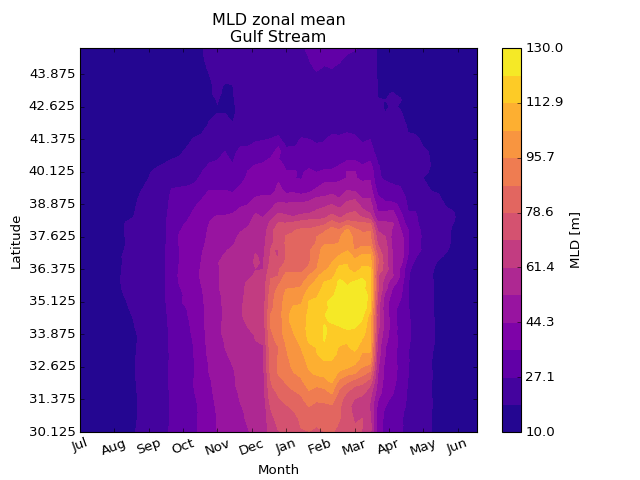

In [17]:
%matplotlib notebook

plt.close()

x = pd.to_datetime(n.week.values)
y =  n.latitude.values
#X, Y = np.meshgrid(x, y)

fig, ax = plt.subplots()

cs = ax.contourf(n.mlotst.T, levels=np.linspace(10., 130., 15), cmap='plasma')

## This is for the position of the Gulf Stream
#ax.plot(ssh.T, linewidth=2, color='w')
#cs2 = ax.contour(n2.mlotst.T, 20, linewidths=0.5, colors='k')

cb = fig.colorbar(cs, ax=ax, orientation='vertical')
cb.set_label('MLD [m]')


plt.xticks(np.arange(n.week.size, step=4.5), months, rotation=20)
plt.yticks(np.arange(len(l), step=5), l[::5])
plt.xlabel('Month')
plt.ylabel('Latitude')

plt.title('MLD zonal mean\nGulf Stream')

#plt.savefig(dir_o + 'Gul-Zonal-MLD-Hov.png.png', bbox_inches='tight')
plt.show()